### Sources

Sources:  
ONS retail sales share of online: [LINK](https://www.ons.gov.uk/businessindustryandtrade/retailindustry/timeseries/j4mc/drsi)  
ONS cpi: [LINK](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/d7bt/mm23)  
ONS rpi: [LINK](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/chaw/mm23)  
ONS effective fx rate: [LINK](https://www.ons.gov.uk/economy/nationalaccounts/balanceofpayments/timeseries/bk67/mret)  
BOE rate: [LINK](https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp)  
GfK CCI: [LINK](https://www.statista.com/statistics/623579/consumer-confidence-in-the-uk/)
  
References:  
Mintel report: [LINK](https://store.mintel.com/report/uk-online-retailing-market-report)

### Setup

In [1]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data folders

raw_data_dir = Path.cwd().parent / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)

processed_data_dir = Path.cwd().parent / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [3]:
output_files = processed_data_dir / "clean_data.csv"

### Import and merge

**ONS data**

In [4]:
ons_csv_datasets = {
    "online_retail_sales_share": raw_data_dir / "series-230925_onlineretailshare.csv",
    "cpi": raw_data_dir / "series-230925_cpi.csv",
    "rpi": raw_data_dir / "series-230925_rpi.csv",
    "eff_fx": raw_data_dir / "series-230925_GBPeffectivefx.csv",
}

In [5]:
all_dfs = []

for name, file_path in ons_csv_datasets.items():
    try:
        with open(file_path, 'r') as f:
            start_row = next(i for i, line in enumerate(f) if '"2014 JAN"' in line)

        df = pd.read_csv(file_path, skiprows=start_row, header=None, names=['date', name])
        df['date'] = df['date'].str.strip('"')
        df[name] = df[name].astype(float)
        all_dfs.append(df)

    except StopIteration:
        print(f"2015 JAN not found in {name}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")

In [6]:
if all_dfs:
    interim_data = all_dfs[0]
    for df in all_dfs[1:]:
        interim_data = interim_data.merge(df, on='date', how='outer')

    # Convert date to datetime and set as index
    interim_data['date'] = pd.to_datetime(interim_data['date'], format='%Y %b')
    interim_data.set_index('date', inplace=True)
    interim_data.index = interim_data.index + MonthEnd(0)
    interim_data.sort_index(inplace=True)

**GFK Consumer Confidence**

In [7]:
file_path = raw_data_dir / 'gfk_consumer_confidence.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
df.index = df.index + MonthEnd(0)
df.sort_index(inplace=True)

interim_data = interim_data.merge(df, left_index=True, right_index=True, how='outer')
interim_data

,online_retail_sales_share,cpi,rpi,eff_fx,cci
date,,,,,
2014-01-31,11.1,99.0,252.6,85.4222,NaN
2014-02-28,10.7,99.5,254.2,85.7378,NaN
2014-03-31,10.8,99.7,254.8,85.5269,NaN
2014-04-30,10.6,100.1,255.7,86.1716,NaN
2014-05-31,10.9,100.0,255.9,86.8395,NaN
...,...,...,...,...,...
2025-04-30,26.3,138.2,402.2,84.6692,98.8
2025-05-31,26.2,138.4,402.9,85.6975,99.0
2025-06-30,26.6,138.9,404.5,85.9689,99.3


**BoE bank rate**

In [8]:
# custom data append - BOE rate
file_path = raw_data_dir / 'boe_rate_changes.csv'

rate = (pd.read_csv(file_path, sep='\t', header=None,
                    names=['date', 'boe_rate'])
        .assign(date=lambda x: pd.to_datetime(x['date'], format='%d %b %y')
                + pd.offsets.MonthEnd(0))
        .set_index('date')
        .sort_index()
        )

cal = pd.date_range('2014-01-31', '2025-08-31', freq='M', name='date').to_frame(index=False)
cal = cal.set_index('date')

cal = cal.join(rate, how='left')
cal['boe_rate'] = cal['boe_rate'].ffill().bfill()

interim_data = interim_data.join(cal)

### Rebase and clip

In [9]:
cpi_2015 = interim_data.loc['2015-01-31', 'cpi']
rpi_2015 = interim_data.loc['2015-01-31', 'rpi']
eff_fx_2015 = interim_data.loc['2015-01-31', 'eff_fx']

interim_data['cpi_15'] = interim_data['cpi'] / cpi_2015 * 100
interim_data['rpi_15'] = interim_data['rpi'] / rpi_2015 * 100
interim_data['eff_fx_15'] = interim_data['eff_fx'] / eff_fx_2015 * 100

interim_data['cpi_inf'] = interim_data['cpi_15'].pct_change(12) * 100   # YoY %
interim_data['rpi_inf'] = interim_data['rpi_15'].pct_change(12) * 100
interim_data['eff_fx_inf'] = interim_data['eff_fx_15'].pct_change(12) * 100

# RPI ex CPI: a positive value means RPI is running hotter than CPI, i.e. the cost-of-living pressure that consumers actually feel (mortgage payments, council tax, petrol, etc.) is higher than the Bank’s target gauge.
# Online shoppers hunt bargains harder in that environment, so the wedge often has a positive coefficient in share models.
interim_data['rpi_ex_cpi'] = interim_data['rpi'] - interim_data['cpi']

/tmp/ipykernel_45367/4236367792.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  interim_data['eff_fx_inf'] = interim_data['eff_fx_15'].pct_change(12) * 100


In [10]:
interim_data = interim_data[interim_data.index >= pd.Timestamp('2015-01-31')]
interim_data = interim_data[interim_data.index <= pd.Timestamp('2025-07-31')]

In [11]:
clean_data = interim_data[['online_retail_sales_share', 'cpi_inf', 'rpi_ex_cpi', 'eff_fx_inf', 'cci', 'boe_rate']].copy()
clean_data.to_csv(output_files)
print(f"Clean data saved to {output_files}")
clean_data

Clean data saved to /home/mikhailarutyunov/projects/time-series-methods/time-series-methods/data/processed/clean_data.csv


,online_retail_sales_share,cpi_inf,rpi_ex_cpi,eff_fx_inf,cci,boe_rate
date,,,,,,
2015-01-31,12.8,0.303030,156.1,2.690870,102.0,0.50
2015-02-28,11.7,0.000000,157.2,5.020539,102.2,0.50
2015-03-31,11.7,0.000000,157.4,5.666404,102.4,0.50
2015-04-30,12.2,-0.199800,158.1,4.593277,102.4,0.50
2015-05-31,11.7,0.100000,158.4,5.130730,102.3,0.50
...,...,...,...,...,...,...
2025-03-31,26.8,2.631579,258.8,2.499037,98.8,4.50
2025-04-30,26.3,3.520599,264.0,2.788687,98.8,4.50
2025-05-31,26.2,3.360717,264.5,3.531531,99.0,4.25


### First look

In [12]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128 entries, 2015-01-31 to 2025-07-31
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   online_retail_sales_share  128 non-null    float64
 1   cpi_inf                    128 non-null    float64
 2   rpi_ex_cpi                 128 non-null    float64
 3   eff_fx_inf                 128 non-null    float64
 4   cci                        128 non-null    float64
 5   boe_rate                   128 non-null    float64
dtypes: float64(6)
memory usage: 7.0 KB


In [13]:
clean_data.describe()

,online_retail_sales_share,cpi_inf,rpi_ex_cpi,eff_fx_inf,cci,boe_rate
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,22.191406,2.994637,197.535156,-0.039730,99.524219,1.578906
std,6.561292,2.900683,34.612522,5.552844,2.491553,1.909081
min,11.500000,-0.199800,156.100000,-18.421262,92.200000,0.100000
25%,16.650000,0.897980,170.975000,-2.872345,98.400000,0.250000
50%,23.250000,2.294932,184.000000,1.476621,100.100000,0.500000
75%,27.025000,3.380585,232.000000,4.187438,101.025000,3.125000
max,37.800000,11.091549,267.200000,7.314945,102.900000,5.250000


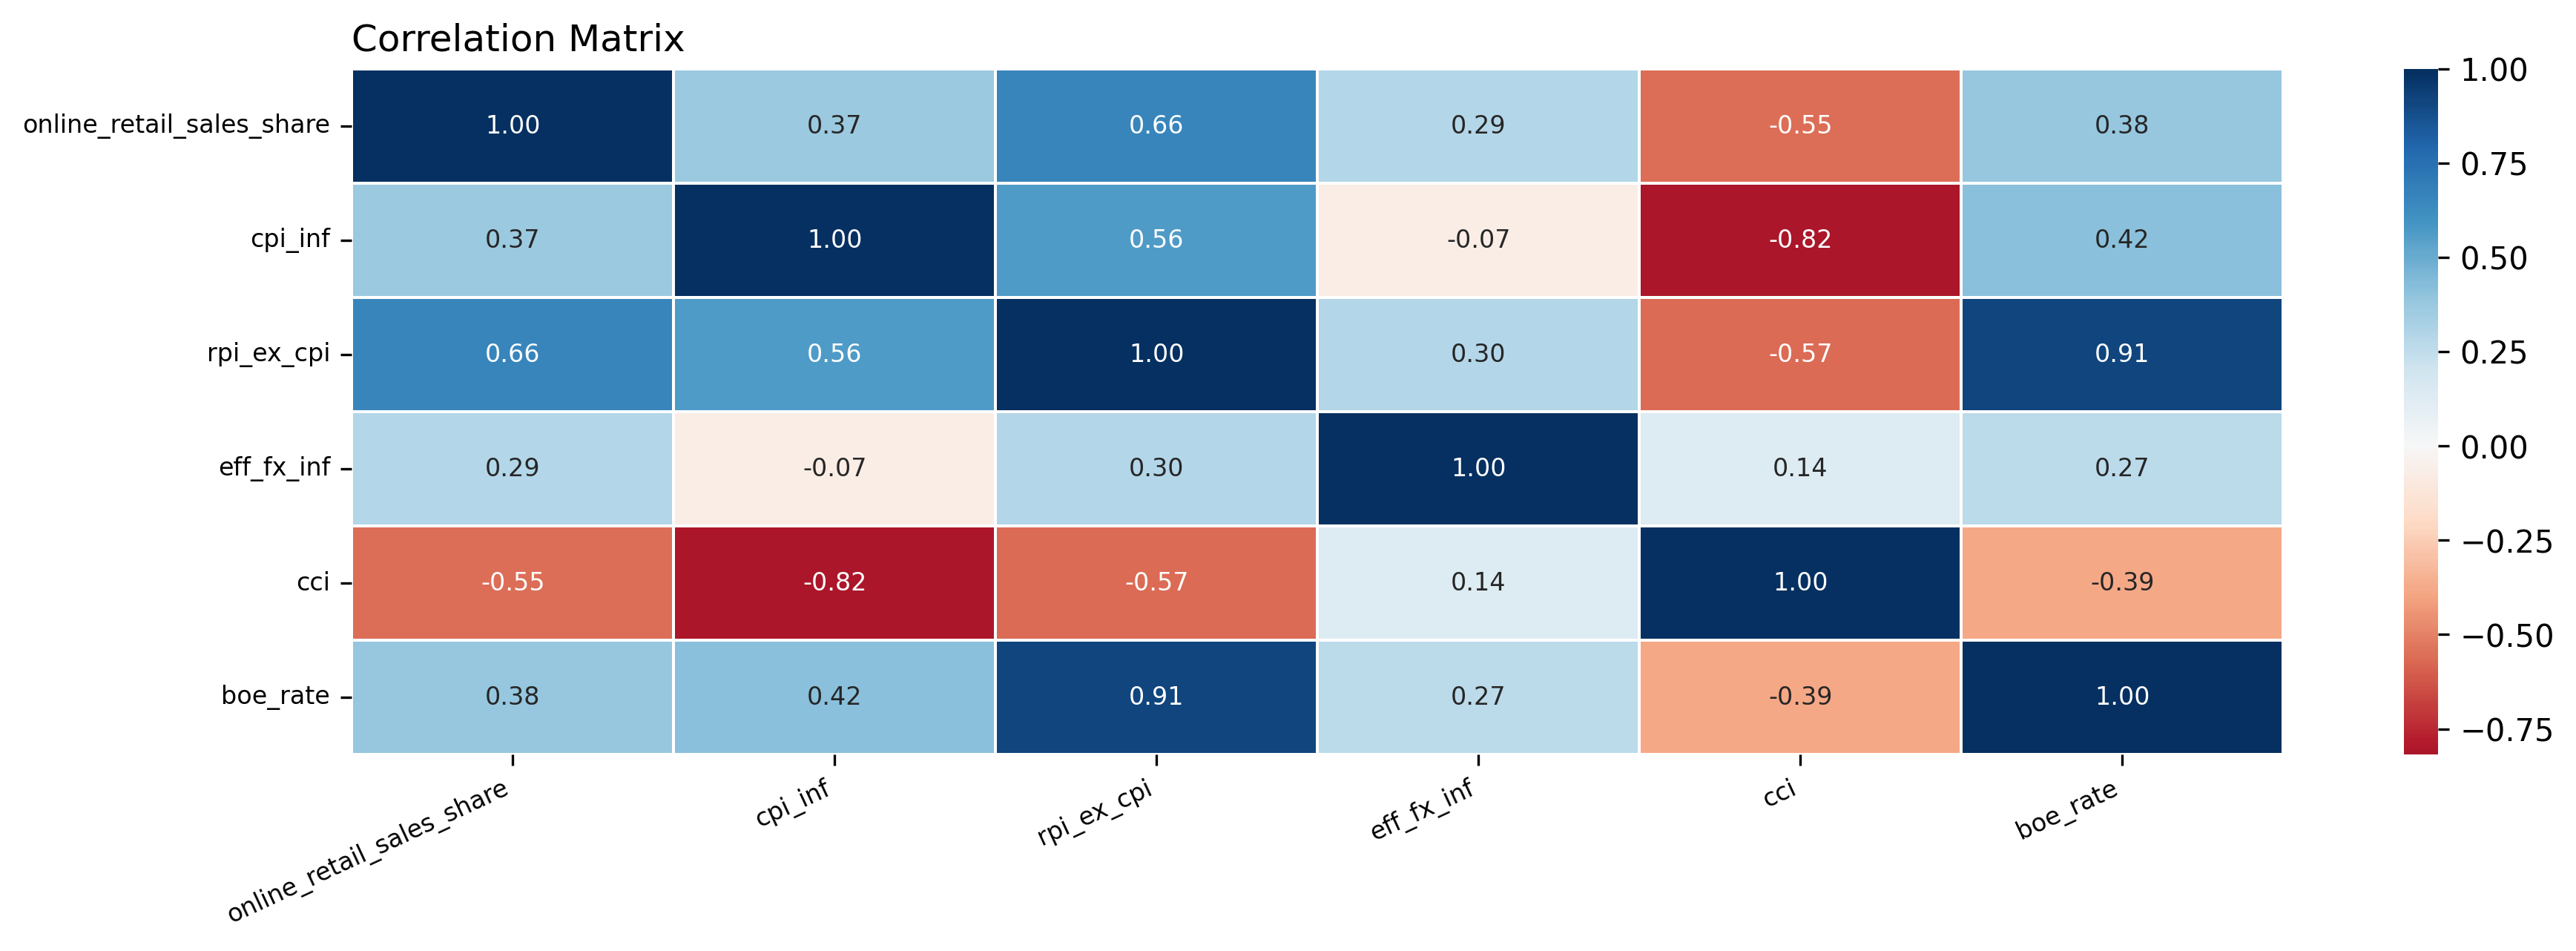

In [14]:
correlation_matrix = clean_data.corr()

plt.figure(figsize=(14, 4), dpi=300)
sns.heatmap(correlation_matrix, annot=True, annot_kws={'size': 8}, fmt='.2f', cmap='RdBu', center=0, linewidths=0.5, linecolor='white')
plt.title('Correlation Matrix', loc='left')
plt.xticks(fontsize=8, rotation=25, ha='right')
plt.yticks(fontsize=8)
# plt.savefig('../outputs/figures/features_correlations.png', bbox_inches='tight', dpi=300)
plt.show()

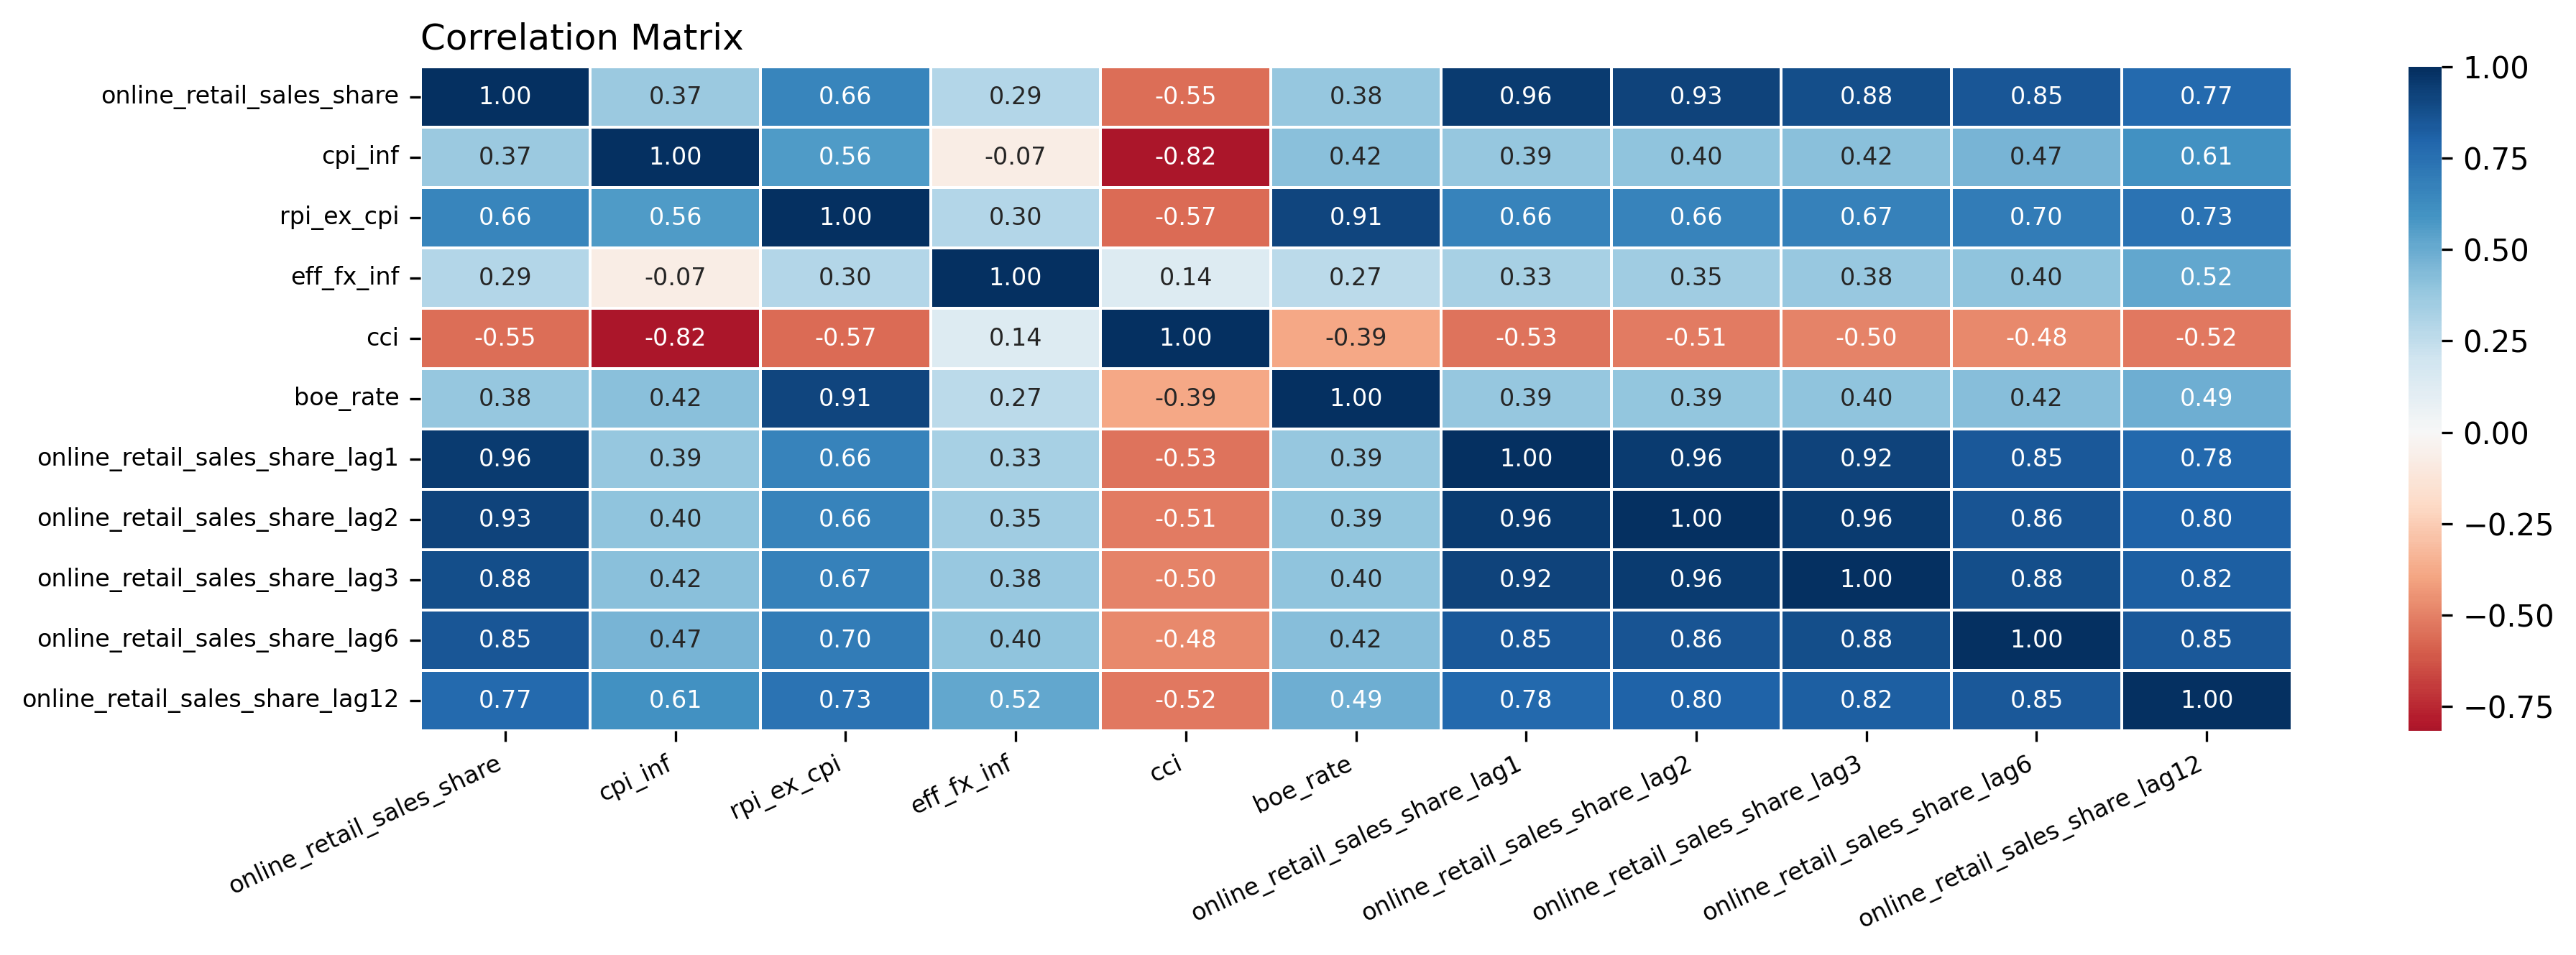

In [18]:
# check correlations with lagged fieatures

clean_data_extended = clean_data.copy()
clean_data_extended['online_retail_sales_share_lag1'] = clean_data_extended['online_retail_sales_share'].shift(1)
clean_data_extended['online_retail_sales_share_lag2'] = clean_data_extended['online_retail_sales_share'].shift(2)
clean_data_extended['online_retail_sales_share_lag3'] = clean_data_extended['online_retail_sales_share'].shift(3)
clean_data_extended['online_retail_sales_share_lag6'] = clean_data_extended['online_retail_sales_share'].shift(6)
clean_data_extended['online_retail_sales_share_lag12'] = clean_data_extended['online_retail_sales_share'].shift(12)

correlation_matrix = clean_data_extended.corr()

plt.figure(figsize=(14, 4), dpi=300)
sns.heatmap(correlation_matrix, annot=True, annot_kws={'size': 8}, fmt='.2f', cmap='RdBu', center=0, linewidths=0.5, linecolor='white')
plt.title('Correlation Matrix', loc='left')
plt.xticks(fontsize=8, rotation=25, ha='right')
plt.yticks(fontsize=8)
# plt.savefig('../outputs/figures/features_correlations.png', bbox_inches='tight', dpi=300)
plt.show()

### Global plot

In [15]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 10,
})

In [16]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#FF6B6B", alpha=0.2, hatch='....', label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#FF6B6B", alpha=0.2, hatch='....', label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#FF6B6B", alpha=0.2, hatch='....', label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#FFD166", alpha=0.2, hatch='....', label='Energy-price crisis')
    }

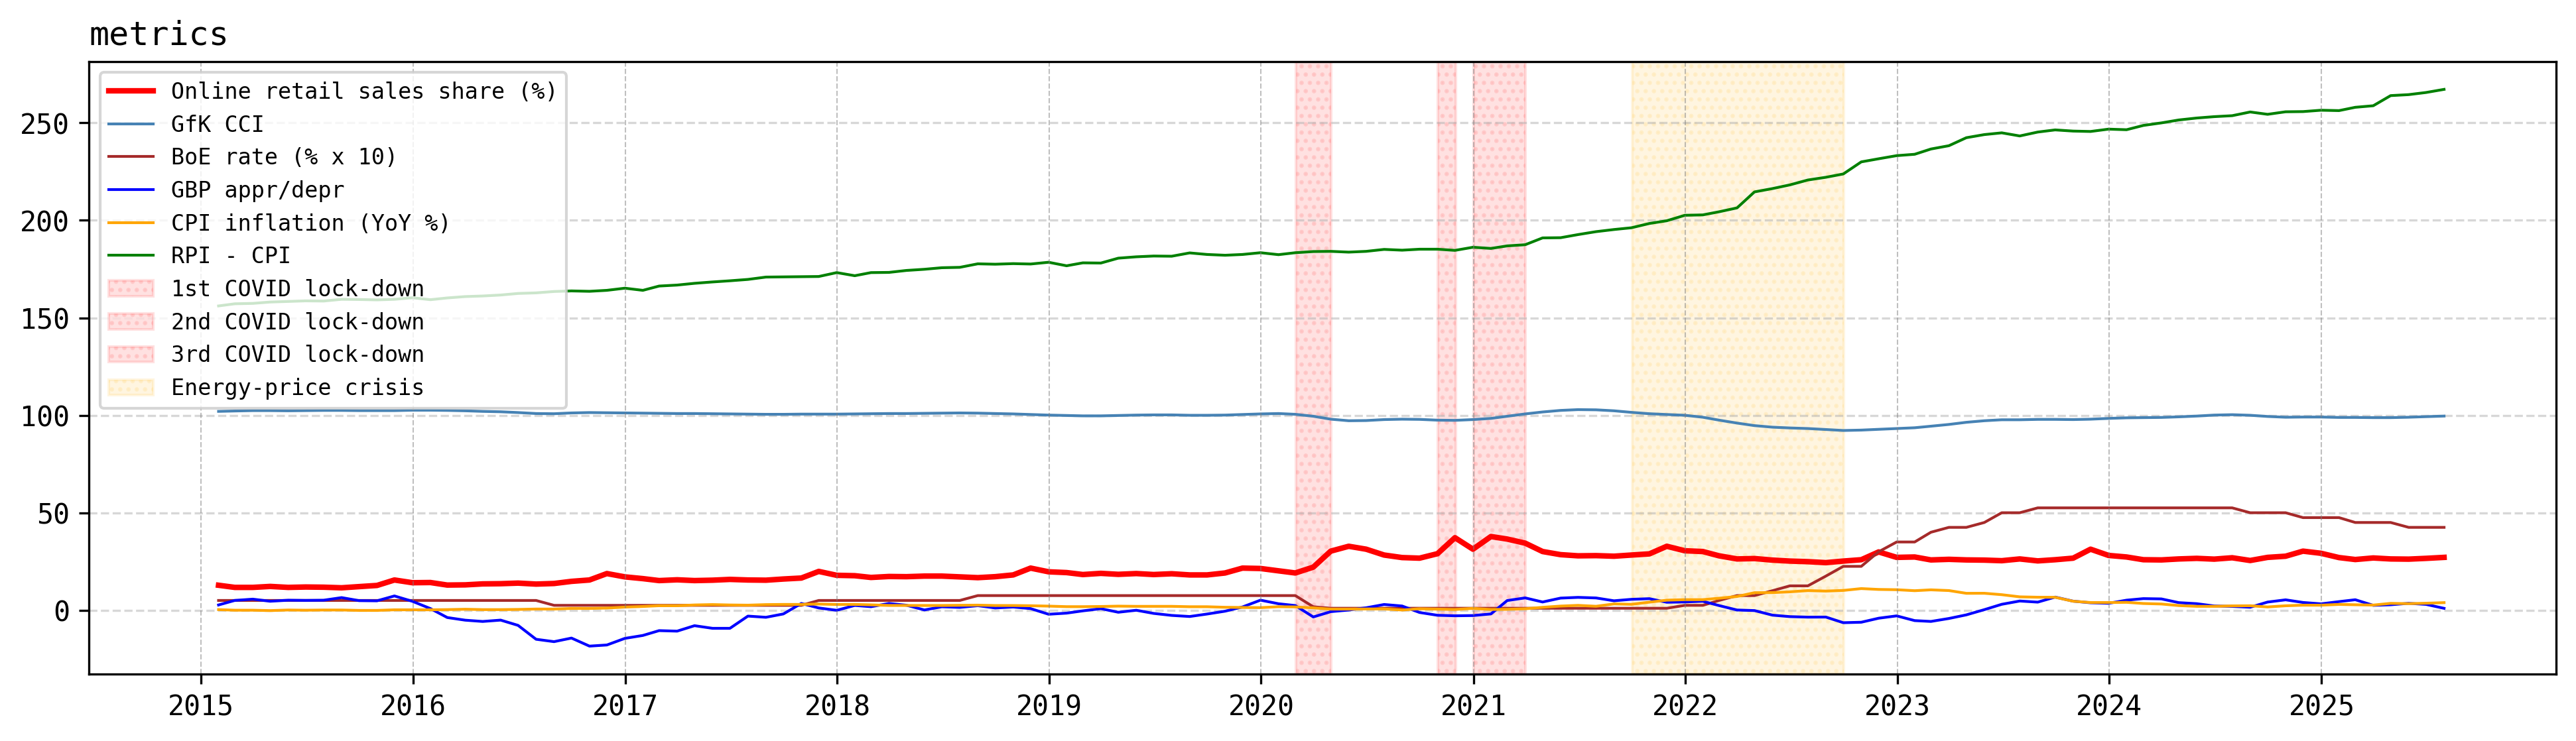

In [17]:
# Oline retail sales share
plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(data=clean_data, x='date', y='online_retail_sales_share', linewidth=2, color='red', label='Online retail sales share (%)')
ax = sns.lineplot(data=clean_data, x='date', y='cci', linewidth=1, color='steelblue', label='GfK CCI')
ax = sns.lineplot(data=clean_data, x='date', y=clean_data['boe_rate'] * 10, linewidth=1, color='brown', label='BoE rate (% x 10)')
ax = sns.lineplot(data=clean_data, x='date', y='eff_fx_inf', linewidth=1, color='blue', label='GBP appr/depr')
ax = sns.lineplot(data=clean_data, x='date', y='cpi_inf', linewidth=1, color='orange', label='CPI inflation (YoY %)')
ax = sns.lineplot(data=clean_data, x='date', y='rpi_ex_cpi', linewidth=1, color='green', label='RPI - CPI')
ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('metrics', loc='left')
# plt.savefig('../outputs/figures/UK_online_retail_share_trend_with_spans.png', bbox_inches='tight', dpi=300)
plt.show()

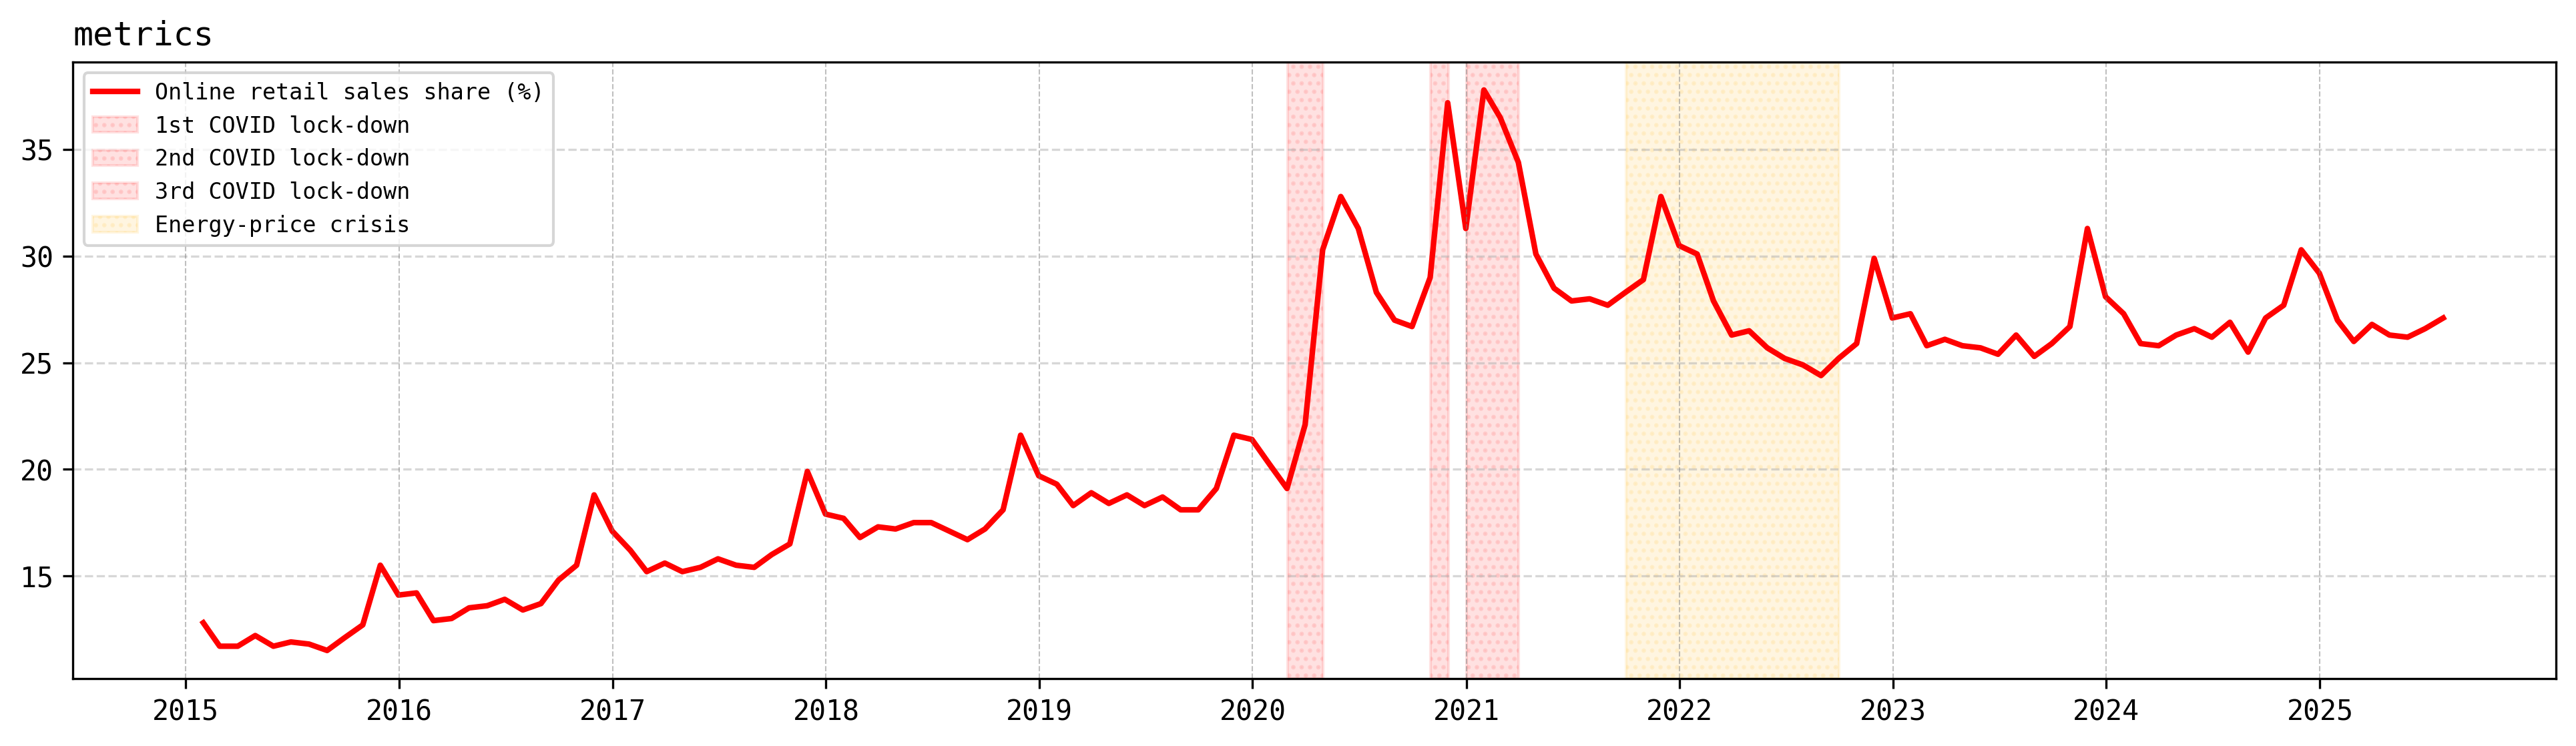

In [19]:
# Oline retail sales share
plt.figure(figsize=(16, 4), dpi=300)
ax = sns.lineplot(data=clean_data, x='date', y='online_retail_sales_share', linewidth=2, color='red', label='Online retail sales share (%)')
# ax = sns.lineplot(data=clean_data, x='date', y='cci', linewidth=1, color='steelblue', label='GfK CCI')
# ax = sns.lineplot(data=clean_data, x='date', y=clean_data['boe_rate'] * 10, linewidth=1, color='brown', label='BoE rate (% x 10)')
# ax = sns.lineplot(data=clean_data, x='date', y='eff_fx_inf', linewidth=1, color='blue', label='GBP appr/depr')
# ax = sns.lineplot(data=clean_data, x='date', y='cpi_inf', linewidth=1, color='orange', label='CPI inflation (YoY %)')
# ax = sns.lineplot(data=clean_data, x='date', y='rpi_ex_cpi', linewidth=1, color='green', label='RPI - CPI')
ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('metrics', loc='left')
# plt.savefig('../outputs/figures/UK_online_retail_share_trend_with_spans.png', bbox_inches='tight', dpi=300)
plt.show()